In [1]:
import numpy as np
from numba import jit
from itertools import product
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
np.set_printoptions(suppress=True, linewidth=100)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [10]:
class PDE_2D:
    
    def __init__(self, lx, ly, ux, uy, nx, ny):
        self.nx, self.ny = nx, ny
        xp, self.hx = np.linspace(lx, ux, nx, retstep=True)
        yp, self.hy = np.linspace(ly, uy, ny, retstep=True)
        self.X, self.Y = np.meshgrid(xp, yp, indexing='ij')
        self.X_flat, self.Y_flat = self.X.flatten(), self.Y.flatten()
        self.L = len(self.X_flat)
        self.X_hat = sp.sparse.dia_matrix(([self.X_flat], 0), shape=(self.L, self.L))
        self.Y_hat = sp.sparse.dia_matrix(([self.Y_flat], 0), shape=(self.L, self.L))
        self._get_laplacian()
        
    def _get_laplacian(self):
        hx2, hy2 = self.hx**2, self.hy**2
        pt_d, pt_i, pt_j = [], [], []
        for k in xrange(self.L):
            x, y = k // self.ny, k % self.ny
            if (x - 2 >= 0 and x + 2 < self.nx) and (y - 2 >= 0 and y + 2 < self.ny):
                pt_i.append(k)
                pt_j.append(k - 2)
                pt_d.append(-1 / (12. * hy2))
                pt_i.append(k)
                pt_j.append(k - 1)
                pt_d.append(4 / (3. * hy2))
                pt_i.append(k)
                pt_j.append(k)
                pt_d.append((-5 / (2. * hy2)) - (5 / (2. * hx2)))
                pt_i.append(k)
                pt_j.append(k + 1)
                pt_d.append(4 / (3. * hy2))
                pt_i.append(k)
                pt_j.append(k + 2)
                pt_d.append(-1 / (12. * hy2))
                pt_i.append(k)
                pt_j.append(k - 2 * self.ny)
                pt_d.append(-1 / (12. * hx2))
                pt_i.append(k)
                pt_j.append(k - self.ny)
                pt_d.append(4 / (3. * hx2))
                pt_i.append(k)
                pt_j.append(k + self.ny)
                pt_d.append(4 / (3. * hx2))
                pt_i.append(k)
                pt_j.append(k + 2 * self.ny)
                pt_d.append(-1 / (12. * hx2))
        self.D_hat = sp.sparse.coo_matrix((pt_d, (pt_i, pt_j)), shape=(self.L, self.L))
        self.D_hat = sp.sparse.csr_matrix(self.D_hat)
        return self.D_hat


def eigensolve(H, k, s):
    """
    Find k eigenvalues near s for the sparse matrix H
    """
    u, v = sp.sparse.linalg.eigs(H, k=k, sigma=s)
    u, v = np.real_if_close(u), np.real_if_close(v)
    arst = np.argsort(u)
    return u[arst], v.T[arst].T

In [33]:
pde = PDE_2D(lx=-1, ly=-1, ux=1, uy=1, nx=50, ny=50)
h2m = 0.038099822119143215
u, v = eigensolve(- h2m * pde.D_hat + abs(pde.X_hat), k=10, s=1.2)

[ 1.          1.          1.          1.          1.          1.          1.          1.          1.2751742
  1.27702118]


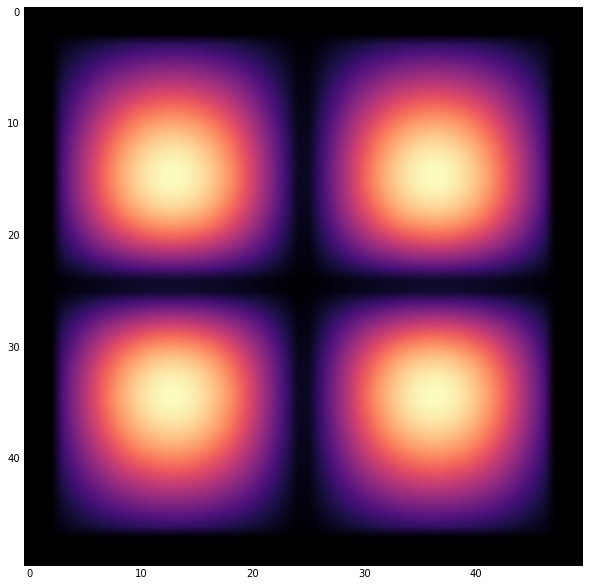

In [35]:
print u
Z = v[:, -1].reshape(50, 50)
Z[:3], Z[-3:], Z[:, :3], Z[:, -3:] = 0, 0, 0, 0
plt.imshow(abs(Z), cmap='magma')
plt.show()